In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CLASSES = 3
EPOCHS = 50

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillages',
    shuffle = True,
    seed = 123,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    )

Found 2152 files belonging to 3 classes.


In [4]:
for image_batch, label_batch in data.take(1):
    print(image_batch.shape)
    print(label_batch)

(32, 255, 255, 3)
tf.Tensor([1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0], shape=(32,), dtype=int32)


In [5]:
class_names = data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

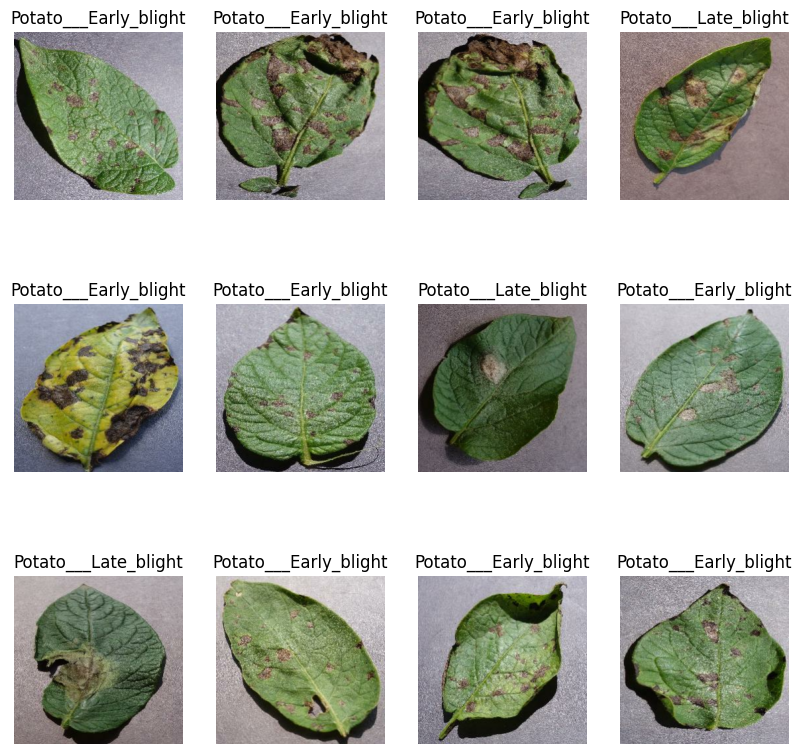

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
def splitdata(data, train_size=0.8, test_size=0.1, valid_size=0.1, shuffle=True):
    if shuffle:
        data = data.shuffle(buffer_size=10000, seed=123)

    total_count = 0
    for _ in data:
        total_count += 1

    train_count = int(train_size * total_count)
    test_count = int(test_size * total_count)
    valid_count = total_count - train_count - test_count

    train_ds = data.take(train_count)
    test_ds = data.skip(train_count).take(test_count)
    valid_ds = data.skip(train_count + test_count).take(valid_count)

    return train_ds, test_ds, valid_ds


In [8]:
train_ds, test_ds, valid_ds = splitdata(data)

In [9]:
len(train_ds)

54

In [10]:
resize_scaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
])

In [11]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
data_augmentation  = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("verticle_and_horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

In [13]:
n_classes = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)  # Include channel dimension

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    resize_scaling,
    data_augmentation,
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),  # Softmax for multi-class
])


d:\python3.10\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = valid_ds,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.4971 - loss: 0.9146 - val_accuracy: 0.6992 - val_loss: 0.7945
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.7201 - loss: 0.6815 - val_accuracy: 0.8164 - val_loss: 0.4320
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.8245 - loss: 0.4550 - val_accuracy: 0.8594 - val_loss: 0.3696
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.8601 - loss: 0.3316 - val_accuracy: 0.8633 - val_loss: 0.3614
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.8993 - loss: 0.2449 - val_accuracy: 0.9258 - val_loss: 0.2304
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.9011 - loss: 0.2325 - val_accuracy: 0.9219 - val_loss: 0.1763
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9156 - loss: 0.2014 - val_accuracy: 0.9258 - val_loss: 0.1761
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9281 - loss: 0.1940 - val_accuracy: 0.9062 - v

In [17]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - accuracy: 1.0000 - loss: 0.0037


In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
acc = history.history['accuracy']
loss = history.history['loss']
val_ac = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [30]:
len(acc)

50

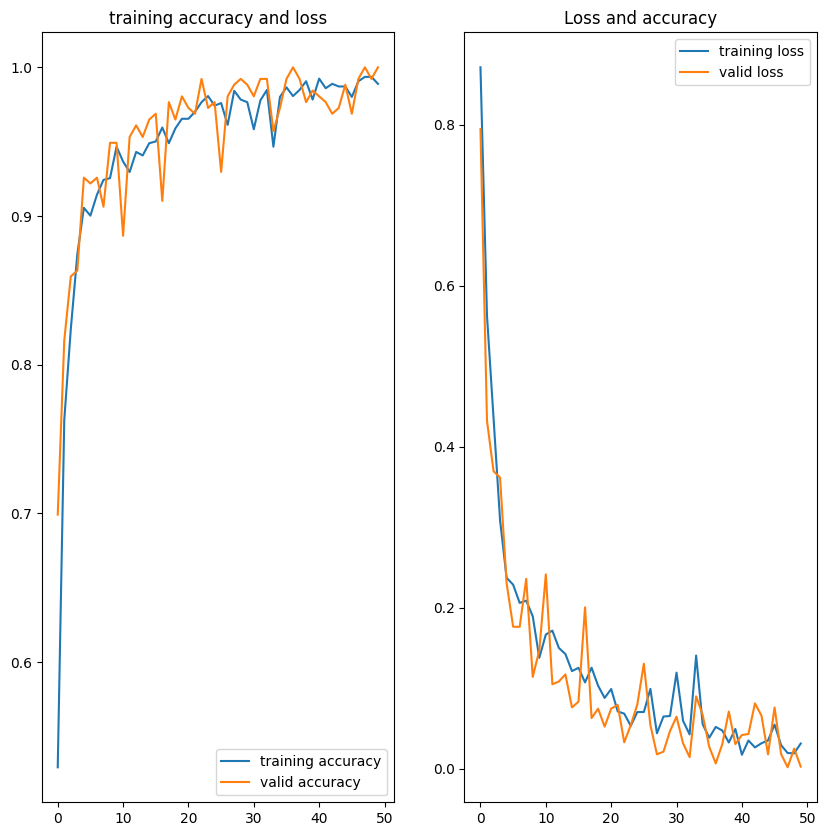

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'training accuracy')
plt.plot(range(EPOCHS), val_ac, label = 'valid accuracy')
plt.title('training accuracy and loss')
# plt.axis("off")
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label = 'valid loss')
plt.title('Loss and accuracy')
# plt.axis('off')
plt.legend(loc = 'upper right')
plt.show()


actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
predicted label: Potato___Early_blight


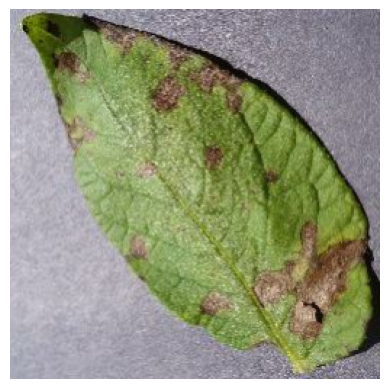

In [47]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    
    print(f"actual label: {class_names[label_batch[0]]}") 
    prediction = model.predict(image_batch)
    print(f"predicted label: {class_names[np.argmax(prediction[0])]}")
    plt.axis('off')

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return prediction_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


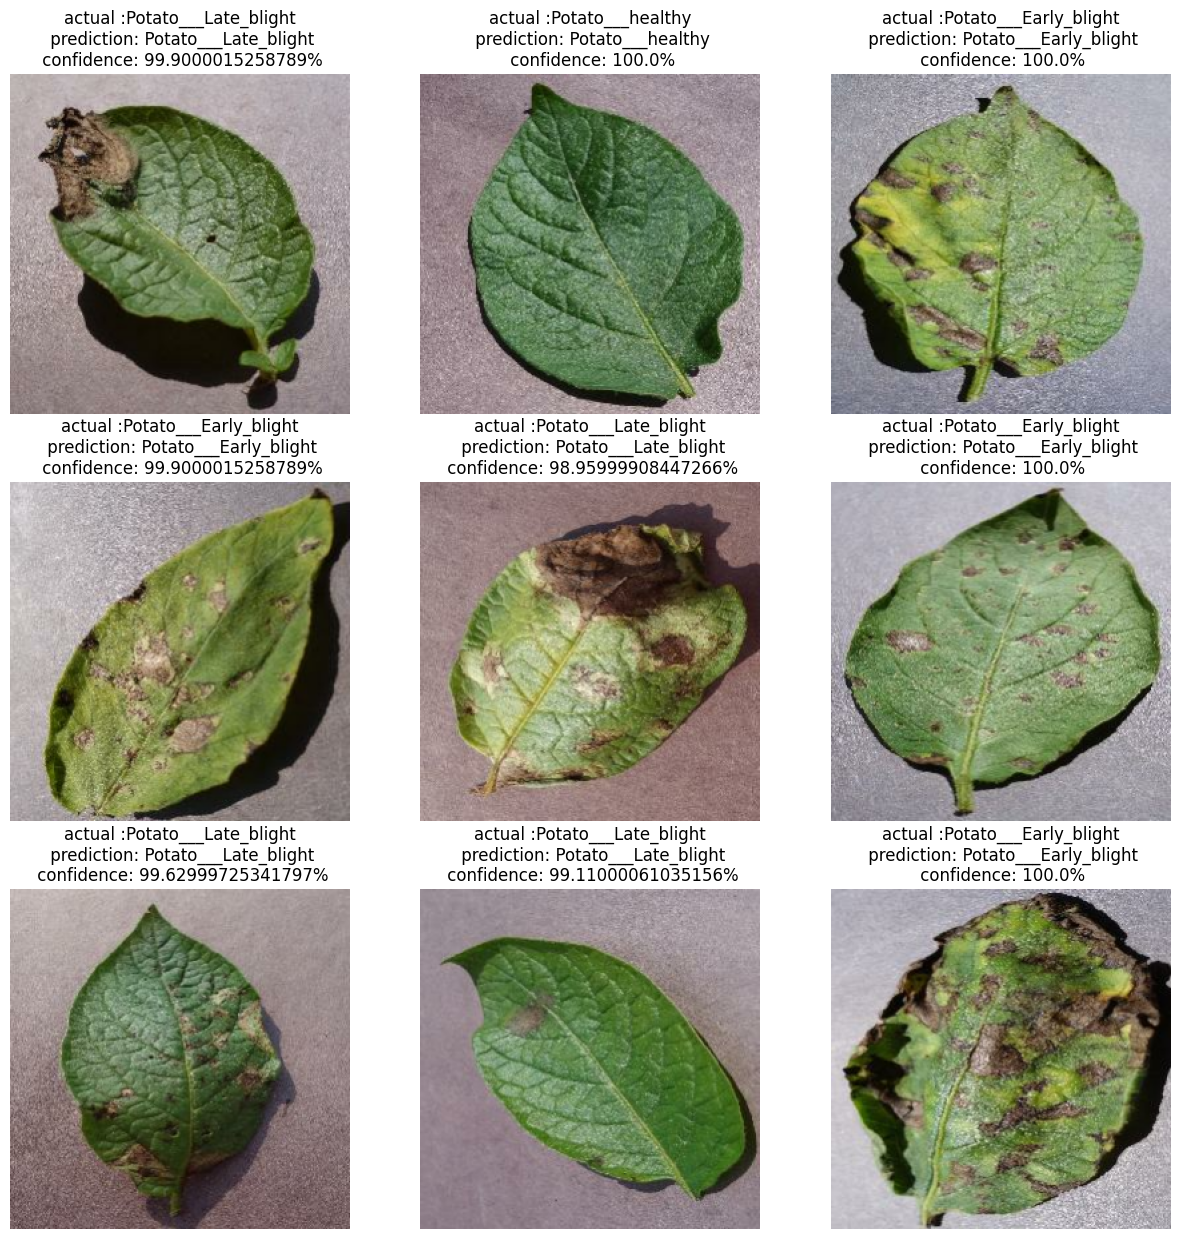

In [74]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        prediction_clas, confidence = predict(model, image_batch[i].numpy())
        actual_label = class_names[label_batch[i]]
        # print(f"actual label: {c}") 
        # print(f'prediction label: {prediction_clas}')
        # print(f'confidence:{confidence}') 
        plt.title(f"actual :{actual_label}\n prediction: {prediction_clas}\n confidence: {confidence}%"  )
        plt.axis('off')

In [96]:
# import os 
# model_version = max([int(i) for i in os.listdir("./models")+ [0]]) +1
# model.save(f"./models/{model_version}")

In [1]:
import os

version = 3
base_dir = f"models/{version}"
os.makedirs(base_dir, exist_ok=True)

# Save in all formats
model.save(os.path.join(base_dir, "model.keras"))
model.save(os.path.join(base_dir, "model.h5"))
model.export(os.path.join(base_dir, "saved_model"))


NameError: name 'model' is not defined

In [1]:
import cpuinfo

info = cpuinfo.get_cpu_info()
print("AVX supported:", 'avx' in info['flags'])
print("AVX2 supported:", 'avx2' in info['flags'])


AVX supported: True
AVX2 supported: True


In [4]:
from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import numpy as np
from io import BytesIO
from PIL import Image
import tensorflow as tf

app = FastAPI()

import requests

# Allow CORS (adjust origins as needed)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # For testing, allow all. Restrict in production.
    allow_methods=["POST"],
    allow_headers=["*"],
)

MODEL = tf.keras.models.load_model(r"D:\Code\python\Potato_Leaf_Diseas\models\1\saved_model")
CLASS_NAMES = ["Early Blight", "Late Blight", "Healthy"]

@app.get("/ping")
async def ping():
    return {"message": "Hello, I am alive"}

def read_file_as_image(data) -> np.ndarray:
    image = Image.open(BytesIO(data)).convert("RGB")
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    return image

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    image = read_file_as_image(await file.read())
    img_batch = np.expand_dims(image, 0)

    predictions = MODEL.predict(img_batch)
    predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
    confidence = float(np.max(predictions[0]))

    return {
        'class': predicted_class,
        'confidence': confidence
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run("app:app", host="localhost", port=8000, reload=True)

INFO:     Will watch for changes in these directories: ['d:\\Code\\python\\Potato_Leaf_Diseas']
INFO:     Uvicorn running on http://localhost:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [15796] using StatReload
INFO:     Stopping reloader process [15796]
